# Instalando o Aeon

In [ ]:
!pip install -U aeon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 15.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
from numba import njit, prange

In [ ]:
RANDOM_STATE = 42

# Testes com o Rocket

## Importando dataset

In [ ]:
from aeon.datasets import load_osuleaf
import matplotlib.pyplot as plt

In [ ]:
X_train, y_train = load_osuleaf(split="train")
X_test, y_test = load_osuleaf(split="test")

X_train.shape

(200, 1, 427)

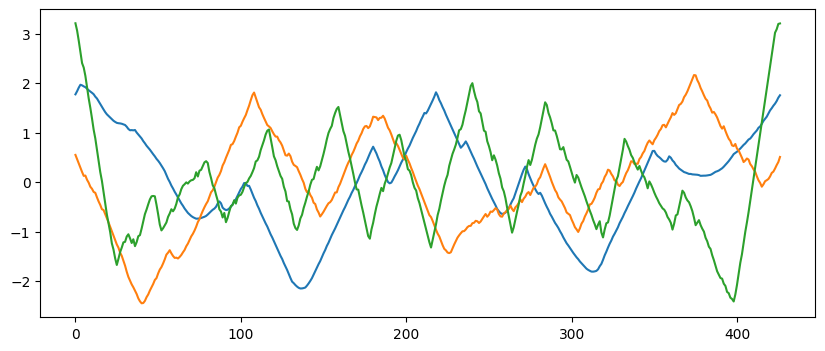

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(X_train[8].T)
plt.plot(X_train[0].T)
plt.plot(X_train[10].T)

## Testando o Rocket do Aeon

In [ ]:
from aeon.transformations.collection.convolution_based import Rocket
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
rocket = Rocket(num_kernels = 20000)

In [ ]:
X_train_feat = rocket.fit_transform(X_train)
X_test_feat = rocket.transform(X_test)

In [ ]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
rfc.fit(X_train_feat, y_train)
y_hat = rfc.predict(X_test_feat)

In [ ]:
print(accuracy_score(y_hat, y_test))

0.8429752066115702


# Implementação Original do Rocket


In [ ]:
@njit("Tuple((float64[:],int32[:],float64[:],int32[:],int32[:]))(int64,int64)")
def generate_kernels(input_length, num_kernels):

    candidate_lengths = np.array((7, 9, 11), dtype = np.int32)
    lengths = np.random.choice(candidate_lengths, num_kernels)

    weights = np.zeros(lengths.sum(), dtype = np.float64)
    biases = np.zeros(num_kernels, dtype = np.float64)
    dilations = np.zeros(num_kernels, dtype = np.int32)
    paddings = np.zeros(num_kernels, dtype = np.int32)

    a1 = 0

    for i in range(num_kernels):

        _length = lengths[i]

        _weights = np.random.normal(0, 1, _length)

        b1 = a1 + _length
        weights[a1:b1] = _weights - _weights.mean()

        biases[i] = np.random.uniform(-1, 1)

        dilation = 2 ** np.random.uniform(0, np.log2((input_length - 1) / (_length - 1)))
        dilation = np.int32(dilation)
        dilations[i] = dilation

        padding = ((_length - 1) * dilation) // 2 if np.random.randint(2) == 1 else 0
        paddings[i] = padding

        a1 = b1

    return weights, lengths, biases, dilations, paddings

@njit(fastmath = True)
def apply_kernel(X, weights, length, bias, dilation, padding):

    input_length = len(X)

    output_length = (input_length + (2 * padding)) - ((length - 1) * dilation)

    _ppv = 0
    _max = np.NINF

    end = (input_length + padding) - ((length - 1) * dilation)

    for i in range(-padding, end):

        _sum = bias

        index = i

        for j in range(length):

            if index > -1 and index < input_length:

                _sum = _sum + weights[j] * X[index]

            index = index + dilation

        if _sum > _max:
            _max = _sum

        if _sum > 0:
            _ppv += 1

    return _ppv / output_length, _max

@njit("float64[:,:](float64[:,:],Tuple((float64[::1],int32[:],float64[:],int32[:],int32[:])))", parallel = True, fastmath = True)
def apply_kernels(X, kernels):

    weights, lengths, biases, dilations, paddings = kernels

    num_examples, _ = X.shape
    num_kernels = len(lengths)

    _X = np.zeros((num_examples, num_kernels * 2), dtype = np.float64) # 2 features per kernel

    for i in prange(num_examples):

        a1 = 0 # for weights
        a2 = 0 # for features

        for j in range(num_kernels):

            b1 = a1 + lengths[j]
            b2 = a2 + 2

            _X[i, a2:b2] = apply_kernel(X[i], weights[a1:b1], lengths[j], biases[j], dilations[j], paddings[j])

            a1 = b1
            a2 = b2

    return _X

# Versão Customizada do Rocket

In [ ]:
@njit("float64[:](int64)")
def generate_increasing_kernel(length):
  weights = np.ones(length)
  indices = np.arange(length)
  weights[indices % 2 == 0] = -1
  return weights

In [ ]:
@njit("float64[:](int64)")
def generate_decreasing_kernel(length):
  weights = np.ones(length)
  indices = np.arange(length)
  weights[indices % 2 != 0] = -1
  return weights

In [ ]:
@njit("float64[:](int64)")
def generate_peak_kernel(length):
  weights = np.zeros(length + length//2)

  xmesh = np.linspace(start=0, stop=1, num = length//4+1)[1:]

  filter_left = xmesh**2
  filter_right = filter_left[::-1]

# primeira parte do vetor, é negativa
  weights[0:length//4] = -filter_left
  weights[length//4:length//2] = -filter_right

# segunda parte do vetor, é positiva e com a amplitude dobrada
  weights[length//2:3*length//4] = 2*filter_left
  weights[3*length//4:length] = 2*filter_right

# terceira parte do vetor, é negativa
  weights[length:5*length//4] = -filter_left
  weights[5*length//4:] = -filter_right

  return weights

In [ ]:
@njit("Tuple((float64[:],int32[:],float64[:],int32[:],int32[:]))(int64,int64)")
def generate_kernels(input_length, num_kernels):

    candidate_lengths = np.array((7, 9, 11, 8, 12, 16), dtype = np.int32)
    lengths = np.random.choice(candidate_lengths, num_kernels)

    weights = np.zeros(18*num_kernels, dtype = np.float64)
    biases = np.zeros(num_kernels, dtype = np.float64)
    dilations = np.zeros(num_kernels, dtype = np.int32)
    paddings = np.zeros(num_kernels, dtype = np.int32)

    a1 = 0
    custom_kernel_num = 0

    # generating custom kernels
    peak_kernels = {8: generate_peak_kernel(8), 12: generate_peak_kernel(12), 16: generate_peak_kernel(16)}
    increasing_kernels = {8: generate_increasing_kernel(8), 12: generate_increasing_kernel(12), 16: generate_increasing_kernel(16)}
    decreasing_kernels = {8: generate_decreasing_kernel(8), 12: generate_decreasing_kernel(12), 16: generate_decreasing_kernel(16)}

    for i in range(num_kernels):

        _length = lengths[i]

        _weights = np.random.normal(0, 1, _length)

        # using custom kernels if our lengths are even
        if _length % 2 == 0:
          custom_kernel_num = custom_kernel_num + 1
          kernel_type = np.random.randint(low=0, high=3)

          if kernel_type == 0:
            _weights = increasing_kernels[_length]

          if kernel_type == 1:
            _weights = decreasing_kernels[_length]

          if kernel_type == 2:
            _weights = peak_kernels[_length]
            _length = _length + _length//2
            lengths[i] = _length

        b1 = a1 + _length
        weights[a1:b1] = _weights - _weights.mean()

        biases[i] = np.random.uniform(-1, 1)

        dilation = 2 ** np.random.uniform(0, np.log2((input_length - 1) / (_length - 1)))
        dilation = np.int32(dilation)
        dilations[i] = dilation

        padding = ((_length - 1) * dilation) // 2 if np.random.randint(2) == 1 else 0
        paddings[i] = padding

        a1 = b1

    weights = np.resize(weights, lengths.sum())

    return weights, lengths, biases, dilations, paddings

# Benchmarks

In [ ]:
from statistics import mean
import pandas as pd

In [ ]:
def run_custom_rocket(num_kernels, X_train, X_test, y_test):
  input_length = X_test[0].shape[1]
  kernels = generate_kernels(input_length, num_kernels)

  X_train_transformed = np.array([np.squeeze(smp) for smp in X_train])
  X_test_transformed = np.array([np.squeeze(smp) for smp in X_test])

  X_train_feat = apply_kernels(X_train_transformed, kernels)
  X_test_feat = apply_kernels(X_test_transformed, kernels)

  rfc = RandomForestClassifier(random_state=RANDOM_STATE)
  rfc.fit(X_train_feat, y_train)
  y_hat = rfc.predict(X_test_feat)

  acc = accuracy_score(y_hat, y_test)

  return acc

In [ ]:
acc = run_custom_rocket(500, X_train, X_test, y_test)
print(acc)

0.8553719008264463


In [ ]:
def run_classic_rocket(num_kernels, X_train, X_test, y_test):
  rocket = Rocket(num_kernels = num_kernels)
  X_train_feat = rocket.fit_transform(X_train)
  X_test_feat = rocket.transform(X_test)

  rfc = RandomForestClassifier(random_state=RANDOM_STATE)
  rfc.fit(X_train_feat, y_train)
  y_hat = rfc.predict(X_test_feat)

  acc = accuracy_score(y_hat, y_test)

  return acc

In [ ]:
acc = run_classic_rocket(500, X_train, X_test, y_test)
print(acc)

0.7975206611570248


In [ ]:
def run_both_rockets(num_kernels, X_train, X_test, y_test):
  rocket_acc = run_classic_rocket(num_kernels, X_train, X_test, y_test)
  custom_rocket_acc = run_custom_rocket(num_kernels, X_train, X_test, y_test)

  return rocket_acc, custom_rocket_acc

In [ ]:
print(run_both_rockets(500, X_train, X_test, y_test))

(0.8305785123966942, 0.8347107438016529)


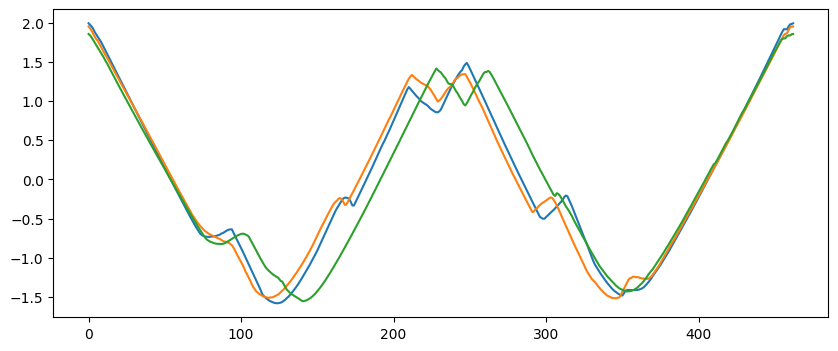

In [ ]:
from aeon.datasets import load_classification

data_train = load_classification(name="Fish", split="train")
X_train = data_train[0]
y_train = data_train[1]

data_test = load_classification(name="Fish", split="test")
X_test = data_test[0]
y_test = data_test[1]

plt.figure(figsize=(10,4))

plt.plot(X_train[8].T)
plt.plot(X_train[0].T)
plt.plot(X_train[10].T)

In [ ]:
accuracies = {}
for num_kernels in [50, 100, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000]:
  classic_accs = []
  custom_accs = []
  for i in range(10):
    classic_acc, custom_acc = run_both_rockets(num_kernels, X_train, X_test, y_test)
    classic_accs.append(classic_acc)
    custom_accs.append(custom_acc)

  print(f'Mean Custom: {mean(custom_accs)}, Mean Classic: {mean(classic_accs)}')
  accuracies[num_kernels] = {'Classic': mean(classic_accs), 'Custom': mean(custom_accs)}

Mean Custom: 0.8594285714285714, Mean Classic: 0.868
Mean Custom: 0.8754285714285714, Mean Classic: 0.8857142857142857
Mean Custom: 0.9011428571428571, Mean Classic: 0.9097142857142857
Mean Custom: 0.9102857142857143, Mean Classic: 0.9131428571428571
Mean Custom: 0.9074285714285715, Mean Classic: 0.9194285714285714
Mean Custom: 0.9051428571428571, Mean Classic: 0.9274285714285715
Mean Custom: 0.9114285714285715, Mean Classic: 0.9319999999999999
Mean Custom: 0.9125714285714286, Mean Classic: 0.9371428571428572


KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame.from_dict(accuracies)
df

In [ ]:
df.to_csv("fish_accuracies.csv")

# Análise de performance

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
dataframe = pd.read_csv("fish_accuracies.csv")

In [ ]:
y_classic = list(dataframe.iloc[0])
y_classic.remove('Classic')

y_custom = list(dataframe.iloc[1])
y_custom.remove('Custom')

kernels = list(dataframe.columns)
kernels.remove('Unnamed: 0')

In [ ]:
plt.figure(figsize = (10, 10))

plt.plot(kernels, y_classic, label = "ROCKET clássico", linestyle = '-')
plt.plot(kernels, y_custom, label = "ROCKET Customizado", linestyle = '--')

plt.xlabel("Quantidade de kernels")
plt.ylabel("Score de acurácia")
plt.title("Acurácia do RFC")
plt.legend()
plt.savefig('fish.png')
plt.show()

In [ ]:
}